In [13]:
!pip install -q transformers datasets

In [15]:
!pip install transformers --upgrade

In [16]:
!pip install accelerate -U

In [4]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
dataset = load_dataset("imagefolder", data_dir="Data_augmentation_Increase data", drop_labels=False)
splits = dataset["train"].train_test_split(test_size=0.1)

train_ds = splits['train']
test_ds = splits['test']  

Resolving data files:   0%|          | 0/13301 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'ACCIDENT',
 1: 'AEROPLANE',
 2: 'AFRAID',
 3: 'AGREE',
 4: 'ALL',
 5: 'ANGRY',
 6: 'ANYTHING',
 7: 'APPRECIATE',
 8: 'BABY',
 9: 'BAD',
 10: 'BARK',
 11: 'BEAUTIFUL',
 12: 'BECOME',
 13: 'BED',
 14: 'BIG',
 15: 'BITE',
 16: 'BORED',
 17: 'BRING',
 18: 'BUSY',
 19: 'CALCULATOR',
 20: 'CALL',
 21: 'CHAT',
 22: 'CLASS',
 23: 'COLD',
 24: 'COLLEGE',
 25: 'COMB',
 26: 'COME',
 27: 'CONGRATULATIONS',
 28: 'COST',
 29: 'CRYING',
 30: 'DANCE',
 31: 'DARE',
 32: 'DIFFERENCE',
 33: 'DILEMMA',
 34: 'DISAPPOINTED',
 35: 'DO',
 36: 'DOCTOR',
 37: 'DONT_CARE',
 38: 'DRINK',
 39: 'ENJOY',
 40: 'FARM',
 41: 'FARMER',
 42: 'FAVOUR',
 43: 'FEVER',
 44: 'FINE',
 45: 'FOOD',
 46: 'FREE',
 47: 'FRIEND',
 48: 'FROM',
 49: 'GO',
 50: 'GOOD',
 51: 'GRATEFUL',
 52: 'HAD',
 53: 'HAPPENED',
 54: 'HAPPY',
 55: 'HEAR',
 56: 'HEART',
 57: 'HELLO',
 58: 'HELP',
 59: 'HI',
 60: 'HIDING',
 61: 'HOW',
 62: 'HUNGRY',
 63: 'HURT',
 64: 'I_ME_MY_MINE',
 65: 'KIND',
 66: 'LEAVE',
 67: 'LIKE',
 68: 'LOVE',
 69: 'MEDICI

In [6]:
import os
import pandas as pd

# Define the path to your dataset
data_dir = "Data_augmentation_Increase data"

# Create a list of classes (subdirectories)
classes = os.listdir(data_dir)

# Initialize a dictionary to store the count of samples per class
class_counts = {}

# Count the number of samples in each class
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_samples = len(os.listdir(class_path))
        class_counts[class_name] = num_samples

# Convert the dictionary to a pandas DataFrame for better visualization
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Number of Samples'])

# Print or visualize the class distribution
print(class_counts_df)


         Class  Number of Samples
0     ACCIDENT                 62
1    AEROPLANE                 62
2       AFRAID                184
3        AGREE                216
4          ALL                124
..         ...                ...
125       WHAT                155
126      WHERE                 77
127        WHO                 76
128      WORRY                 44
129   YOU_YOUR                207

[130 rows x 2 columns]


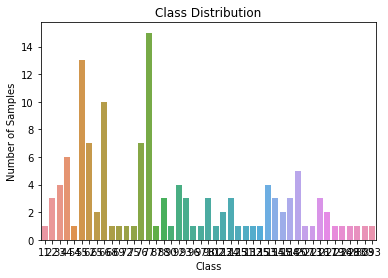

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Number of Samples', data=class_counts_df)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have class_counts_df DataFrame from previous code
class_counts_df.plot(kind='line', x='Class', y='Number of Samples', legend=False)
# Increase the figure size and rotate x-axis labels
plt.figure(figsize=(20, 8))  # Adjust the figure size as needed
plt.xticks(rotation=90, ha="right")  # Rotate labels for better visibility
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Dataset')

# Plot the bar chart

# Show the plot
#plt.tight_layout()  # Ensures labels fit within the figure
plt.show()


In [28]:
!pip install tensorflow==2.6.0

In [14]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
print(processor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [33]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples
     


In [34]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [11]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=64)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([64, 3, 224, 224])
labels torch.Size([64])


In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)
print(model)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

C:\Users\Venus\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Venus\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [25]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"original_word_data_transformers",
    #batch_size = 128,
    #num_epochs = 100,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs_transformers',
    remove_unused_columns=False,
    save_total_limit=3,
)


In [26]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [27]:

import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [143]:

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.110336,0.529677
2,No log,2.854281,0.576258
3,3.384600,2.630778,0.622840
4,3.384600,2.394564,0.639369
5,3.384600,2.191519,0.664162
6,2.859900,2.009576,0.685199
7,2.859900,1.848049,0.707739
8,2.456000,1.691366,0.734786
9,2.456000,1.560585,0.758077
10,2.456000,1.443409,0.775357


TrainOutput(global_step=9400, training_loss=1.500571266336644, metrics={'train_runtime': 19591.0953, 'train_samples_per_second': 30.55, 'train_steps_per_second': 0.48, 'total_flos': 4.643216281293005e+19, 'train_loss': 1.500571266336644, 'epoch': 50.0})

In [147]:
!pip install evaluate

In [148]:
from sklearn.metrics import accuracy_score
import numpy as np
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [149]:
trainer.evaluate(test_ds)

{'eval_loss': 0.2941391170024872,
 'eval_accuracy': 0.9752066115702479,
 'eval_runtime': 29.9886,
 'eval_samples_per_second': 44.384,
 'eval_steps_per_second': 0.7,
 'epoch': 50.0}

In [46]:
!pip install absl-py==2.1.0 flatbuffers==23.5.26 numpy==1.26.4 tensorflow==2.15.0


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
  Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl.metadata (3.6 kB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.5 requires protobuf<4,>=3.11, but you have protobuf 4.25.2 which is incompatible.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
roboflow 0.2.1 requires chardet==4.0.0, but you have chardet 3.0.4 which is incompatible.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.4 which is incompatible.



  Using cached protobuf-4.25.2-cp39-cp39-win_amd64.whl.metadata (541 bytes)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl (2.1 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached protobuf-4.25.2-cp39-cp39-win_amd64.whl (413 kB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl (24 kB)
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-dat

In [39]:
!pip install mediapipe
!pip install tensorflow
!pip install transformers

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires absl-py>=1.0.0, but you have absl-py 0.15.0 which is incompatible.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.11.0 which is incompatible.
tensorflow-intel 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.8.0 which is incompatible.


In [48]:
!pip uninstall tensorflow-intel keras protobuf tensorboard

^C


In [32]:
# Assuming 'test_ds' is your dataset
print(test_ds[0].keys())


dict_keys(['image', 'label'])


In [43]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Replace this with the actual path where you saved your pretrained model
model_path = "isl_trainer/"

# Load the pretrained model
model = ViTForImageClassification.from_pretrained(model_path)

# Load the preprocessor
processor = ViTFeatureExtractor.from_pretrained(model_path)

# Assuming you have defined the validation or test dataset (val_ds or test_ds)
# If not, load your dataset using load_dataset or any other method
# dataset = load_dataset("imagefolder", data_dir="Data_augmentation_Increase data", drop_labels=False)
# splits = dataset["train"].train_test_split(test_size=0.1)

# train_ds = splits['train']
# test_ds = splits['test']

# Define the DataLoader for the validation or test dataset
val_dataloader = DataLoader(test_ds, batch_size=64, collate_fn=collate_fn)

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Make predictions on the validation or test dataset
with torch.no_grad():
    for batch in val_dataloader:
        inputs = batch["pixel_values"]  # Assuming pixel_values is the correct key
        labels = batch["labels"]  # Assuming label is the correct key

        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

# Calculate sensitivity and specificity using scikit-learn
true_positives = np.diag(conf_matrix)
false_negatives = np.sum(conf_matrix, axis=1) - true_positives
false_positives = np.sum(conf_matrix, axis=0) - true_positives
true_negatives = np.sum(conf_matrix) - (false_positives + false_negatives + true_positives)

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Print sensitivity and specificity for each class
for i in range(len(sensitivity)):
    print(f"Class {i}: Sensitivity (Recall) {sensitivity[i]:.4f}, Specificity {specificity[i]:.4f}")

overall_sensitivity = np.sum(true_positives) / np.sum(true_positives + false_negatives)
overall_specificity = np.sum(true_negatives) / np.sum(true_negatives + false_positives)

print(f"Overall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")

C:\Users\Venus\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Confusion Matrix:
[[ 7  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0 15]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        29
           6       1.00      0.93      0.97        15
           7       1.00      1.00      1.00        17
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         4
          12       0.94      1.00      0.97        17
          13       1.00      1.00      1.00   

C:\Users\Venus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Venus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Venus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [51]:
plt.figure(figsize=(150, 120))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=label2id, yticklabels=label2id)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('confusion_matrix_plot.png', format='png', bbox_inches='tight')
plt.show()

In [47]:
plt.savefig('confusion_matrix_plot.png', format='png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

# Prediction

In [1]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import torch

# Replace this with the actual path where you saved your model
model_path = "isl_trainer/"

# Load the model
model = ViTForImageClassification.from_pretrained(model_path)

# Load the preprocessor
processor = ViTFeatureExtractor.from_pretrained(model_path)

# Mapping from predicted index to label
id2label = {'0': 'ACCIDENT', '1': 'AEROPLANE', '2': 'AFRAID', '3': 'AGREE', '4': 'ALL', '5': 'ANGRY', '6': 'ANYTHING', '7': 'APPRECIATE', '8': 'BABY', '9': 'BAD', '10': 'BARK', '11': 'BEAUTIFUL', '12': 'BECOME', '13': 'BED', '14': 'BIG', '15': 'BITE', '16': 'BORED', '17': 'BRING', '18': 'BUSY', '19': 'CALCULATOR', '20': 'CALL', '21': 'CHAT', '22': 'CLASS', '23': 'COLD', '24': 'COLLEGE', '25': 'COMB', '26': 'COME', '27': 'CONGRATULATIONS', '28': 'COST', '29': 'CRYING', '30': 'DANCE', '31': 'DARE', '32': 'DIFFERENCE', '33': 'DILEMMA', '34': 'DISAPPOINTED', '35': 'DO', '36': 'DOCTOR', '37': 'DONT_CARE', '38': 'DRINK', '39': 'ENJOY', '40': 'FARM', '41': 'FARMER', '42': 'FAVOUR', '43': 'FEVER', '44': 'FINE', '45': 'FOOD', '46': 'FREE', '47': 'FRIEND', '48': 'FROM', '49': 'GO', '50': 'GOOD', '51': 'GRATEFUL', '52': 'HAD', '53': 'HAPPENED', '54': 'HAPPY', '55': 'HEAR', '56': 'HEART', '57': 'HELLO', '58': 'HELP', '59': 'HI', '60': 'HIDING', '61': 'HOW', '62': 'HUNGRY', '63': 'HURT', '64': 'I_ME_MY_MINE', '65': 'KIND', '66': 'LEAVE', '67': 'LIKE', '68': 'LOVE', '69': 'MEDICINE', '70': 'MEET', '71': 'NAME', '72': 'NICE', '73': 'NOT', '74': 'NUMBER', '75': 'OLD_AGE', '76': 'ON_THE_WAY', '77': 'OUTSIDE', '78': 'PHONE', '79': 'PLACE', '80': 'PLEASE', '81': 'POUR', '82': 'PREPARE', '83': 'PROMISE', '84': 'REALLY', '85': 'REPEAT', '86': 'ROOM', '87': 'SCHOOL', '88': 'SERVE', '89': 'SHIRT', '90': 'SIKH', '91': 'SITTING', '92': 'SLEEP', '93': 'SLOWER', '94': 'SOFTLY', '95': 'SOMETHING', '96': 'SOME_HOW', '97': 'SOME_ONE', '98': 'SORRY', '99': 'SO_MUCH', '100': 'SPEAK', '101': 'STOCK', '102': 'STOP', '103': 'STUBBORN', '104': 'SURE', '105': 'TAKE_CARE', '106': 'TAKE_TIME', '107': 'TALK', '108': 'TELL', '109': 'THANK', '110': 'THAT', '111': 'THINGS', '112': 'THINK', '113': 'THIRSTY', '114': 'TIRED', '115': 'TODAY', '116': 'TRAIN', '117': 'TRUST', '118': 'TRUTH', '119': 'TURN_ON', '120': 'UNDERSTAND', '121': 'WANT', '122': 'WATER', '123': 'WEAR', '124': 'WELCOME', '125': 'WHAT', '126': 'WHERE', '127': 'WHO', '128': 'WORRY', '129': 'YOU_YOUR'}

# Example: Prepare input image for inference
image_path = "Data_keypoint_30/ANYTHING/0.jpg"
image = Image.open(image_path)
inputs = processor(images=image, return_tensors="pt")

# Perform inference
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get the predicted index
predicted_index = torch.argmax(predictions, dim=1).item()

# Map the index to label
predicted_label = id2label[str(predicted_index)]

# Print the predicted label
print("Predicted Label:", predicted_label)


C:\Users\Venus\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\utils\_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
C:\Users\Venus\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


C:\Users\Venus\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Predicted Label: ANYTHING
